In [168]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext Cython
%load_ext autoreload
%autoreload 2

from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['savefig.dpi'] = 1.5 * matplotlib.rcParams['savefig.dpi']

import numpy as np
import scipy as sp
import sys,os,glob,random,h5py
import healpy as hp
import AnisCoefficients_pix as anis

try:
    from IPython.core.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
def figsize(scale):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

plt.rcParams.update(plt.rcParamsDefault)
params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],#, r'\usepackage{/Users/staylor/Research/NANOGrav/apjfonts}'],
        'text.usetex':True,
        #'axes.color_cycle': ['b', 'lime', 'r', 'purple', 'g', 'c', 'm', 'orange', 'darkblue', \
                                #'darkcyan', 'y','orangered','chartreuse','brown','deeppink','lightgreen', 'k'],
        #'font.serif':cm,
        'figure.figsize': figsize(0.5)}
plt.rcParams.update(params)

In [40]:
def orfFromMap_fast(psr_locs, usermap, response=None):
    """
    Calculate the correlation basis matrices using the pixel-space
    transormations

    @param psr_locs:    Location of the pulsars [phi, theta]
    @param usermap:     Provide a healpix map for GW power

    Note: GW directions are in direction of GW propagation
    """
    if response is None:
        npsrs = len(psr_locs)
        pphi = psr_locs[:,0]
        ptheta = psr_locs[:,1]
        
        # Create the pixels
        nside = hp.npix2nside(len(usermap))
        npixels = hp.nside2npix(nside)
        pixels = hp.pix2ang(nside, np.arange(npixels), nest=False)
        gwtheta = pixels[0]
        gwphi = pixels[1]

        # Create the signal response matrix
        F_e = anis.signalResponse_fast(ptheta, pphi, gwtheta, gwphi)
    elif response is not None:
        F_e = response

    # Double the power (one for each polarization)
    sh = np.array([usermap, usermap]).T.flatten()

    # Create the cross-pulsar covariance
    hdcov_F = np.dot(F_e * sh, F_e.T)

    # The pulsar term is added (only diagonals: uncorrelated)
    return hdcov_F + np.diag(np.diag(hdcov_F))

In [41]:
def orf_overlap(orf1, orf2):
    return np.dot(orf1[np.triu_indices(orf1.shape[0],k=1)], orf2[np.triu_indices(orf2.shape[0],k=1)])

## Isotropic GWB sky

In [99]:
match = np.zeros((99,100))
for jj,npsr in enumerate(np.arange(2,101)):
    for ii in range(100):
        theta = np.arccos(np.random.uniform(-1.,1.,size=npsr))
        phi = np.random.uniform(0.,2.0*np.pi,size=npsr)

        orf = orfFromMap_fast(np.column_stack([phi,theta]), np.ones(12288))
        match[jj,ii] = orf_overlap(orf,orf) / (npsr*(npsr-1.0)/2.)
         
        if ii%100:
            clear_output()
            print '\r', npsr, ii
            sys.stdout.flush() 

100 99


In [111]:
np.save('orf_match_ptarandomize.npy',match)

In [101]:
import scipy.interpolate as interp
import scipy.ndimage.filters as filter
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

In [102]:
def confinterval(samples, sigma=0.68, onesided=False, weights=None,
                 bins=40, type='equalArea'):
    """
    Given a list of samples, return the desired cofidence intervals.
    Returns the minimum and maximum confidence levels
    @param samples: Samples that we wish to get confidence intervals
    @param sigmalevel: Sigma level 1, 2, or 3 sigma, will return
                       corresponding confidence limits
    @param onesided: Boolean to use onesided or twosided confidence
                     limits.
    @param weights: Histogram Weights.
    @param bins: Number of histogram bins
    @param type: equalArea: Integrates from sides of posterior
                 minArea: Brute force search for confidence interval with smallest
                          paramter range
                 equalProb: Integrates from MAP downwards
    """

    ecdf = ECDF(samples)

    # Create the binning
    x = np.linspace(min(samples), max(samples), 1000)
    ecdf = ECDF(samples)
    y = ecdf(x)

    # Find the intervals
    if type == 'equalArea' or onesided:
        if onesided:
            x2max = x[np.flatnonzero(y<=sigma)[-1]]
            x2min = x2max
        else:
            x2min = x[np.flatnonzero(y<=0.5*(1-sigma))[-1]]
            x2max = x[np.flatnonzero(y>=1-0.5*(1-sigma))[0]]

    if type == 'minArea':
        delta, xmin, xmax = np.zeros(len(y)), np.zeros(len(y)), np.zeros(len(y))
        start = 0
        for ii in range(len(y)):
            ind = np.flatnonzero((y-y[ii])>=sigma)
            if len(ind) == 0:
                delta[ii] = np.inf
            else:
                delta[ii] = x[ind[0]] - x[ii]
                xmin[ii] = x[ii]
                xmax[ii] = x[ind[0]]

        minind = np.argmin(delta)
        x2min = xmin[minind]
        x2max = xmax[minind]


    if type == 'equalProb' and not(onesided):
        hist, xedges = np.histogram(samples, bins=bins, weights=weights)
        xedges = np.delete(xedges, -1) + 0.5*(xedges[1] - xedges[0])
        x = np.linspace(xedges.min(), xedges.max(), 10000)
        ifunc = interp.interp1d(xedges, hist, kind='linear')
        sortlik = np.sort(ifunc(x))
        sortlik /= sortlik.sum()
        ind = np.argsort(ifunc(x))
        idx = np.flatnonzero(np.cumsum(sortlik) > 1-sigma)
        x2min = x[ind][idx].min()
        x2max = x[ind][idx].max()

    return x2min, x2max

In [220]:
match_spread = np.zeros((99,5))
for jj,npsr in enumerate(np.arange(2,101)):
    match_spread[jj,[0,4]] = np.array(confinterval(match[jj,:]**0.5, sigma=0.95, onesided=False))
    match_spread[jj,[1,3]] = np.array(confinterval(match[jj,:]**0.5, sigma=0.68, onesided=False))
    match_spread[jj,2] = np.mean(match[jj,:]**0.5)

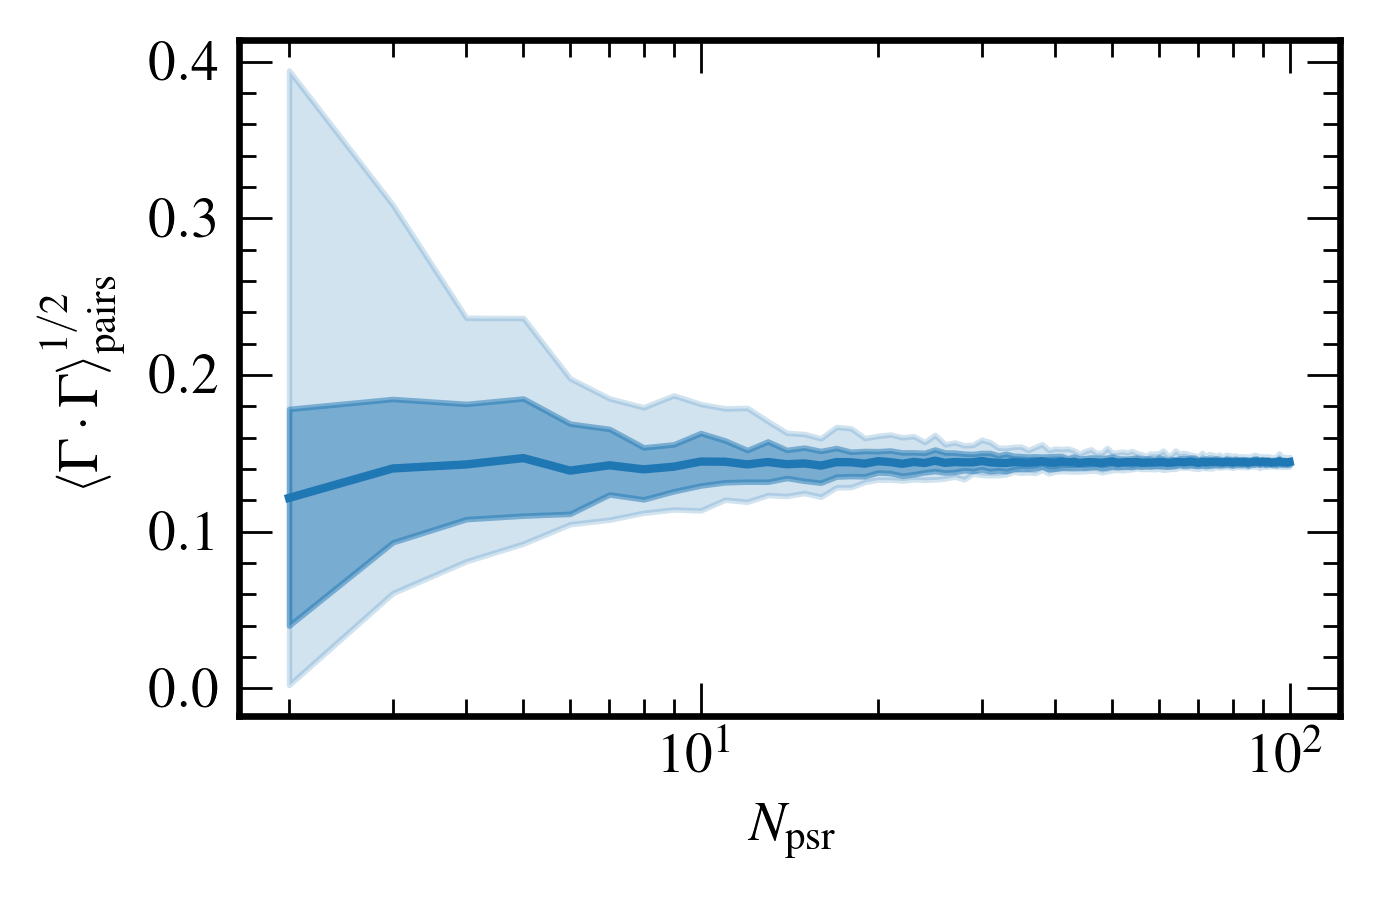

In [221]:
plt.fill_between(np.arange(2,101), match_spread[:,0], match_spread[:,4], color='C0', alpha=0.2)
plt.fill_between(np.arange(2,101), match_spread[:,1], match_spread[:,3], color='C0', alpha=0.5)

plt.plot(np.arange(2,101), match_spread[:,2], color='C0')

plt.xscale('log')

plt.xlabel('$N_\mathrm{psr}$')
plt.ylabel(r'$\langle \Gamma\cdot\Gamma \rangle_\mathrm{pairs}^{1/2}$')

plt.minorticks_on()
plt.tick_params(which='both',direction='in',tick2On=True)
#plt.legend(loc='upper right',ncol=2,frameon=False)     

In [376]:
rho_fracspread = []
for jj,npsr in enumerate(np.arange(2,101)):
    #rho_fracspread.append( np.diff(np.array(confinterval(match[jj,:]**0.5, sigma=0.68, onesided=False))) / 
    #                      np.mean(match[jj,:]**0.5) )
    rho_fracspread.append( np.std(match[jj,:]**0.5,ddof=1) / np.mean(match[jj,:]**0.5) )

In [377]:
z = np.poly1d(np.polyfit(np.log(np.arange(2,101)), np.log(np.array(rho_fracspread)), 1).T.flatten())

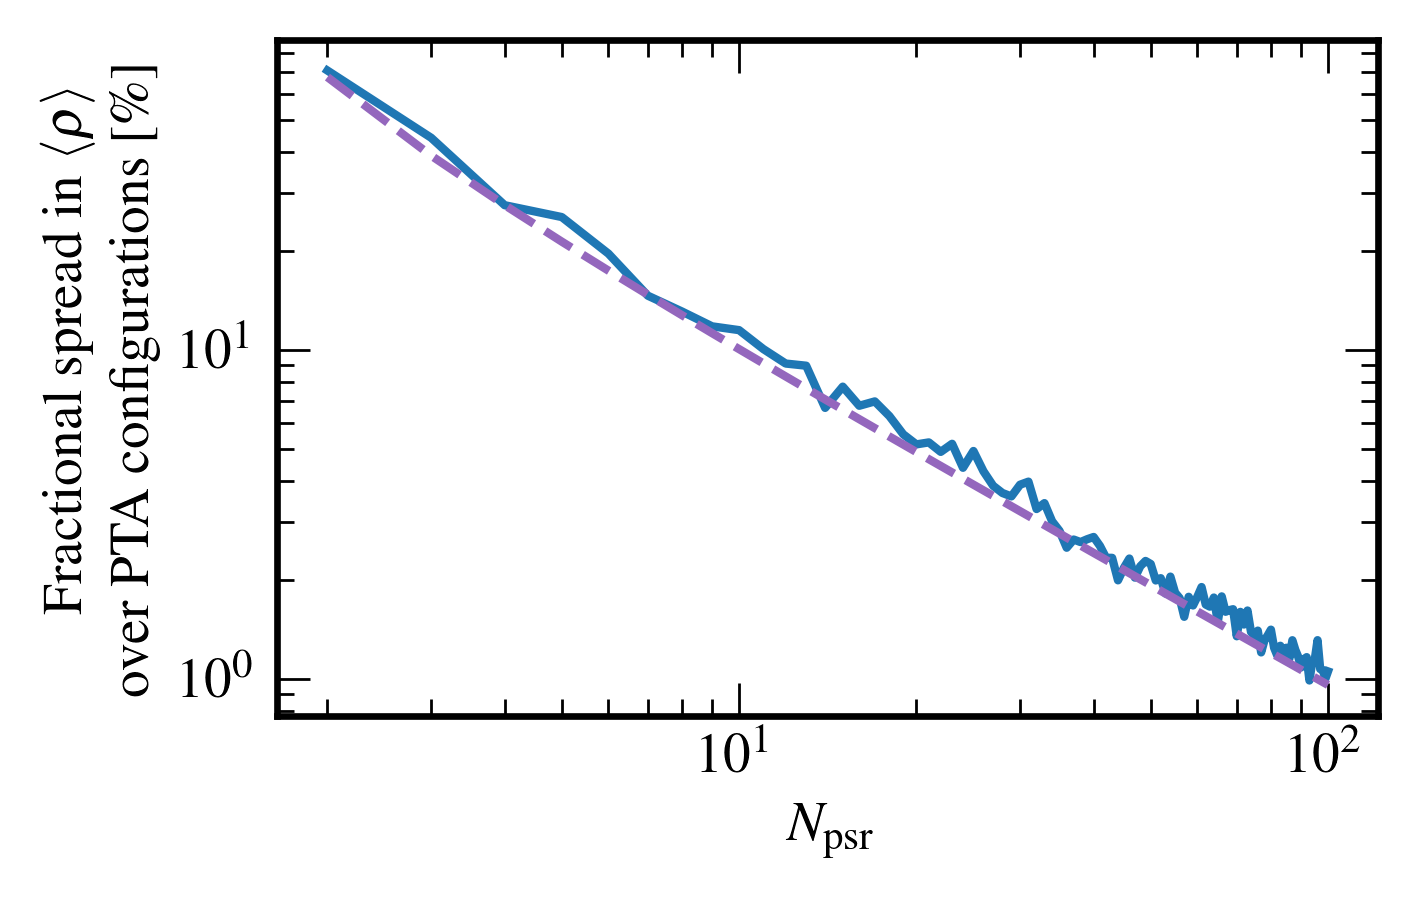

In [378]:
npairs = np.arange(2,101) * (np.arange(2,101)-1.) / 2.
plt.plot(np.arange(2,101), np.array(rho_fracspread)*100, color='C0')
#plt.plot(np.arange(2,101), 100 * np.exp(z(np.log(np.arange(2,101)))), color='C1', linestyle='dashed')
#plt.plot(np.arange(2,101), 100 * np.exp(-np.log(np.arange(2,101)) + 0.75), color='C2', linestyle='dashed')
#plt.plot(np.arange(2,101), 100 * 2./np.arange(2,101), color='C3', linestyle='dashed')
plt.plot(np.arange(2,101), 100 * 0.6738102648353916/np.sqrt(npairs), color='C4', linestyle='dashed')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('$N_\mathrm{psr}$')
plt.ylabel(r'Fractional spread in $\langle\rho\rangle$ \\ over PTA configurations [$\%$]')

plt.minorticks_on()
plt.tick_params(which='both',direction='in',tick2On=True)
#plt.legend(loc='upper right',ncol=2,frameon=False)     

In [288]:
rho_fracspread[0]

0.70555737660615936

In [371]:
w1 = sp.special.lambertw(-1. / (3. * np.exp(1)**(1./6.))).real
w2 = sp.special.lambertw(-1. / (3. * np.exp(1)**(1./6.)), k=-1).real

(1./w1**2.0 + 2./w1 - (2.0*w2 + 1.)/w2**2.0) / 12.

0.11969034539466102

In [372]:
#vari = 0.1197
#vari = sp.integrate.quad(lambda x: np.abs(1.5*x*np.log(x) - 0.25*x + 0.5), 0., 1.0)[0]
w1 = sp.special.lambertw(-1. / (3. * np.exp(1)**(1./6.))).real
w2 = sp.special.lambertw(-1. / (3. * np.exp(1)**(1./6.)), k=-1).real

vari = (1./w1**2.0 + 2./w1 - (2.0*w2 + 1.)/w2**2.0) / 12.

((1./48.)-vari**2.0)**0.5 / vari

0.67398431309028217

In [323]:
beta = 0.256
100.**0.5 * (beta**2. / (1. + beta**2.)) * 0.5*100.*(100.-1.) * (1./np.sqrt(48.))

439.43675963546991

In [327]:
npsr=100
theta = np.arccos(np.random.uniform(-1.,1.,size=npsr))
phi = np.random.uniform(0.,2.0*np.pi,size=npsr)

/Users/staylor/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in arccos


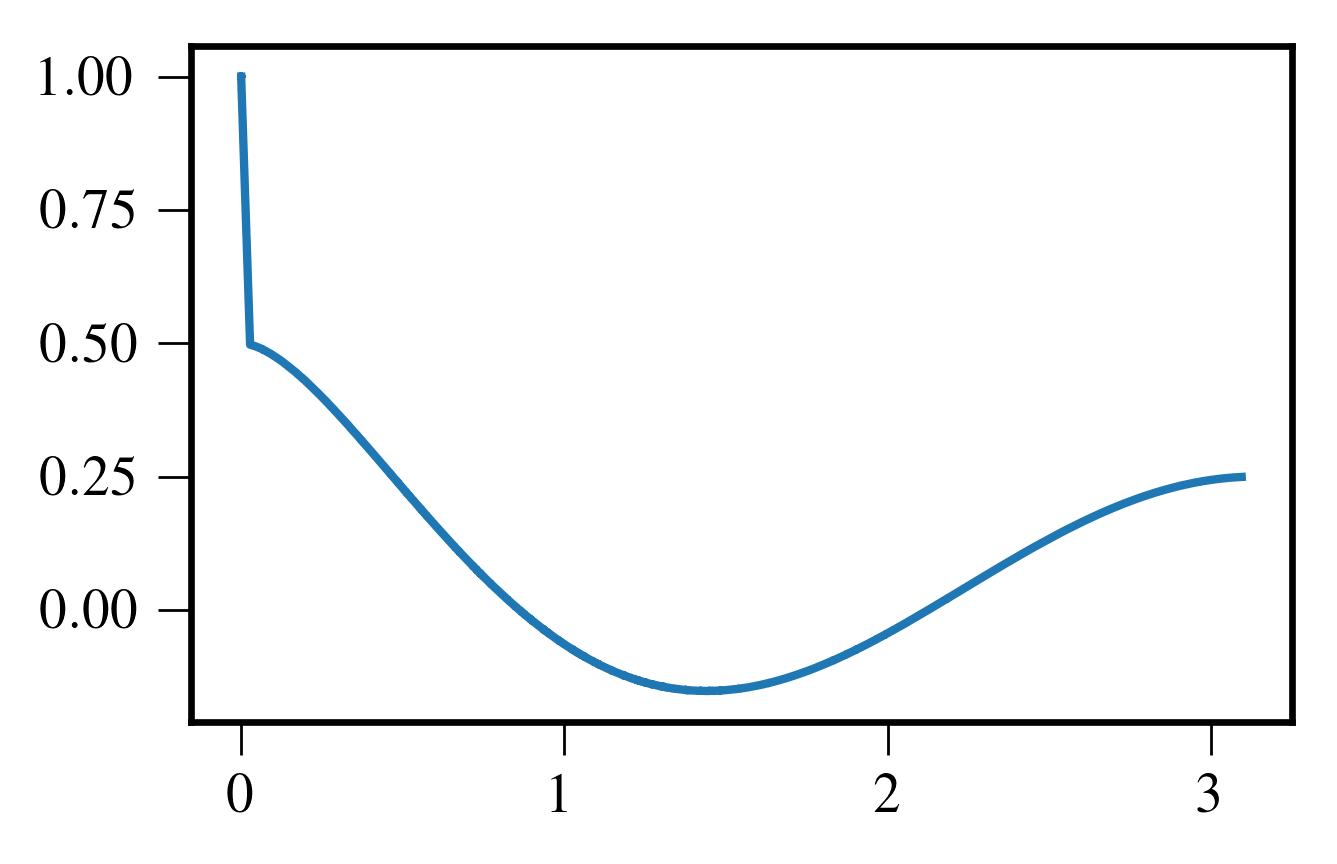

In [328]:
orf = orfFromMap_fast(np.column_stack([phi,theta]), np.ones(12288))
psr_locs = np.array([np.sin(theta)*np.cos(phi), 
                     np.sin(theta)*np.sin(phi), 
                     np.cos(theta)]).T
zeta = np.arccos(np.dot(psr_locs, psr_locs.T))

inds = np.triu_indices(npsr)
zeta = zeta[inds]

plt.plot(np.sort(zeta), np.array(orf[inds])[np.argsort(zeta)])

In [329]:
zeta[np.isnan(zeta)] = 4.0
zeta[zeta==0.0] = 4.0

/Users/staylor/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


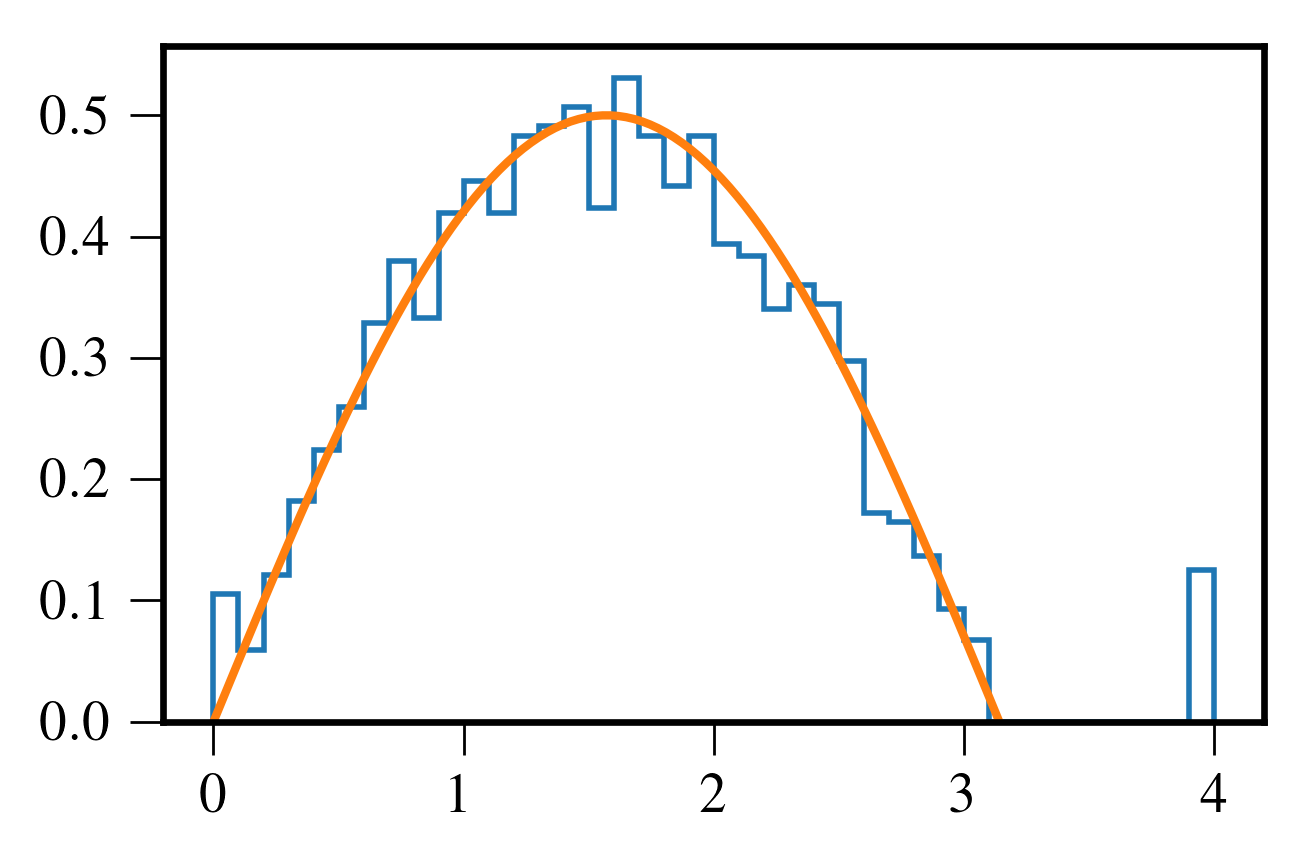

In [330]:
n, _, _ = plt.hist(zeta, bins=40, histtype='step', normed=True)
plt.plot(np.linspace(0.0,np.pi,100.), 0.5*np.sin(np.linspace(0.0,np.pi,100.)))

In [331]:
realpop = np.load('./data/steve_realpop.npy')
realpop[realpop < 0.0] = 0.0

hotspot = np.load('./data/steve_hotspot.npy')
hotspot[hotspot < 0.0] = 0.0

singlesource = np.zeros(len(hotspot))
singlesource[np.random.randint(0,len(hotspot))] = len(hotspot)

In [332]:
orf_realpop = orfFromMap_fast(np.column_stack([phi,theta]), realpop)
orf_hotspot = orfFromMap_fast(np.column_stack([phi,theta]), hotspot)
orf_singlesource = orfFromMap_fast(np.column_stack([phi,theta]), singlesource)

orf_isotropic = orfFromMap_fast(np.column_stack([phi,theta]), np.ones(len(realpop)))

In [333]:
print orf_overlap(orf_realpop, orf_isotropic)**0.5 / orf_overlap(orf_realpop, orf_realpop)**0.5
print orf_overlap(orf_hotspot, orf_isotropic)**0.5 / orf_overlap(orf_hotspot, orf_hotspot)**0.5
print orf_overlap(orf_singlesource, orf_isotropic)**0.5 / orf_overlap(orf_singlesource, orf_singlesource)**0.5

0.976812583304
0.582810418309
0.42584296617


In [403]:
np.dot(singlesource, np.ones(12288)) / np.sqrt( np.dot(singlesource, singlesource) * np.dot(np.ones(12288), np.ones(12288)) )

0.009021097956087902

## Point-source sky

In [351]:
spot_phi = 0.75*np.pi
spot_theta = np.pi/4.0

nside=32
spot_pix = hp.ang2pix(nside,spot_theta,spot_phi)
spot_vec = hp.ang2vec(spot_theta,spot_phi)

point_map = np.zeros(12288)
#point_map[np.random.randint(0,len(hotspot))] = 12288.0
point_map[spot_pix] = 12288.0

In [352]:
match_point = np.zeros((99,100))
for jj,npsr in enumerate(np.arange(2,101)):
    for ii in range(100):
        theta = np.arccos(np.random.uniform(-1.,1.,size=npsr))
        phi = np.random.uniform(0.,2.0*np.pi,size=npsr)

        orf = orfFromMap_fast(np.column_stack([phi,theta]), point_map)
        match_point[jj,ii] = orf_overlap(orf,orf) / (npsr*(npsr-1.0)/2.)
         
        if ii%100:
            clear_output()
            print '\r', npsr, ii
            sys.stdout.flush() 

100 99


In [364]:
np.save('orf_match_point_ptarandomize.npy',match_point)

In [353]:
match_point_spread = np.zeros((99,5))
for jj,npsr in enumerate(np.arange(2,101)):
    match_point_spread[jj,[0,4]] = np.array(confinterval(match_point[jj,:]**0.5, sigma=0.95, onesided=False))
    match_point_spread[jj,[1,3]] = np.array(confinterval(match_point[jj,:]**0.5, sigma=0.68, onesided=False))
    match_point_spread[jj,2] = np.mean(match_point[jj,:]**0.5)

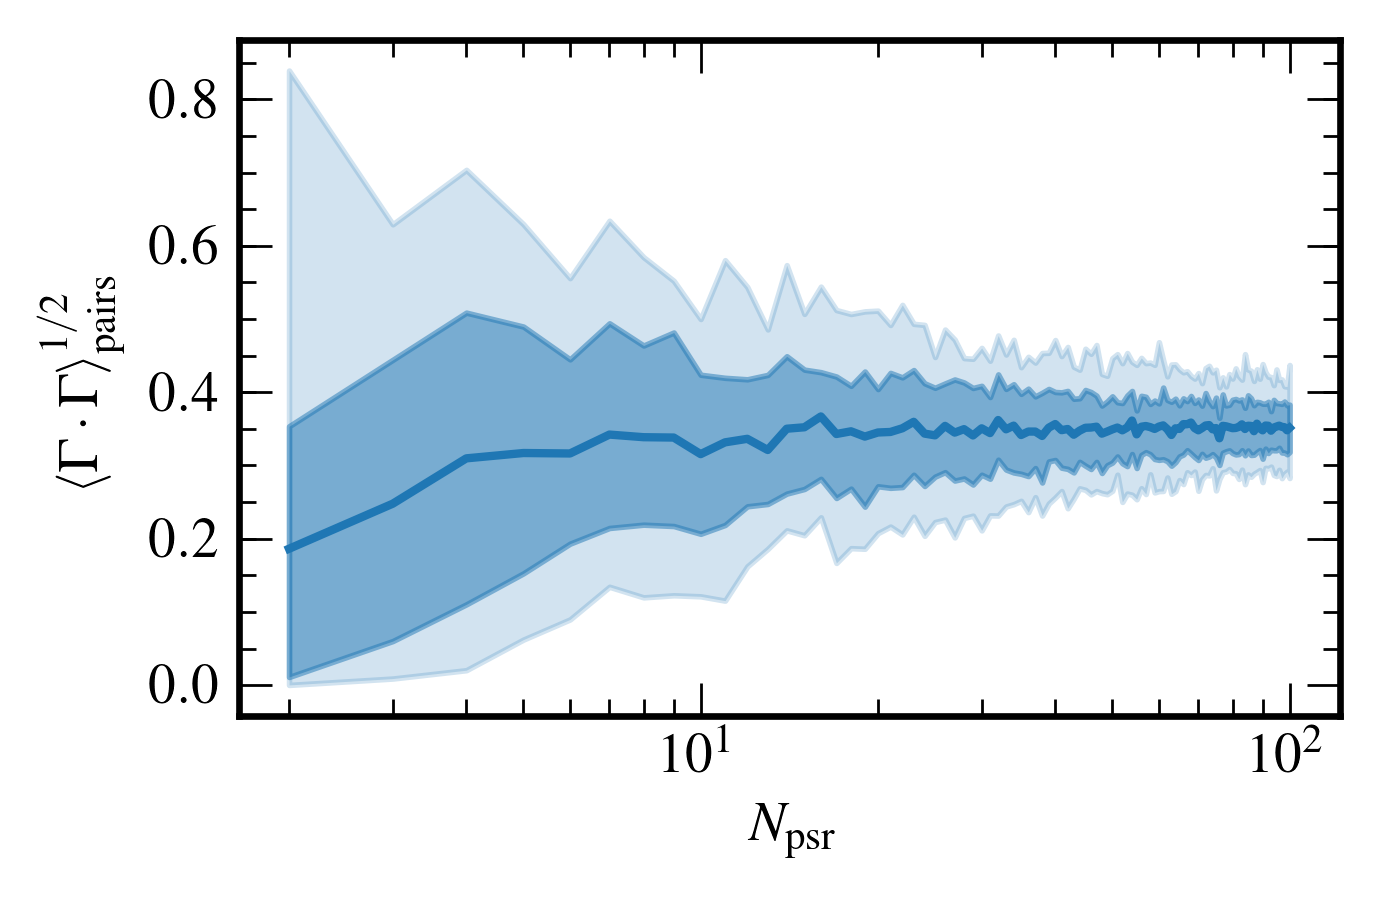

In [354]:
plt.fill_between(np.arange(2,101), match_point_spread[:,0], match_point_spread[:,4], color='C0', alpha=0.2)
plt.fill_between(np.arange(2,101), match_point_spread[:,1], match_point_spread[:,3], color='C0', alpha=0.5)

plt.plot(np.arange(2,101), match_point_spread[:,2], color='C0')

plt.xscale('log')

plt.xlabel('$N_\mathrm{psr}$')
plt.ylabel(r'$\langle \Gamma\cdot\Gamma \rangle_\mathrm{pairs}^{1/2}$')

plt.minorticks_on()
plt.tick_params(which='both',direction='in',tick2On=True)
#plt.legend(loc='upper right',ncol=2,frameon=False)     

In [355]:
rho_fracspread_point = []
for jj,npsr in enumerate(np.arange(2,101)):
    #rho_fracspread_point.append( np.diff(np.array(confinterval(match_point[jj,:]**0.5, sigma=0.68, onesided=False))) / 
    #                      np.mean(match_point[jj,:]**0.5) )
    rho_fracspread_point.append( np.std(match_point[jj,:]**0.5,ddof=1) / np.mean(match_point[jj,:]**0.5) )

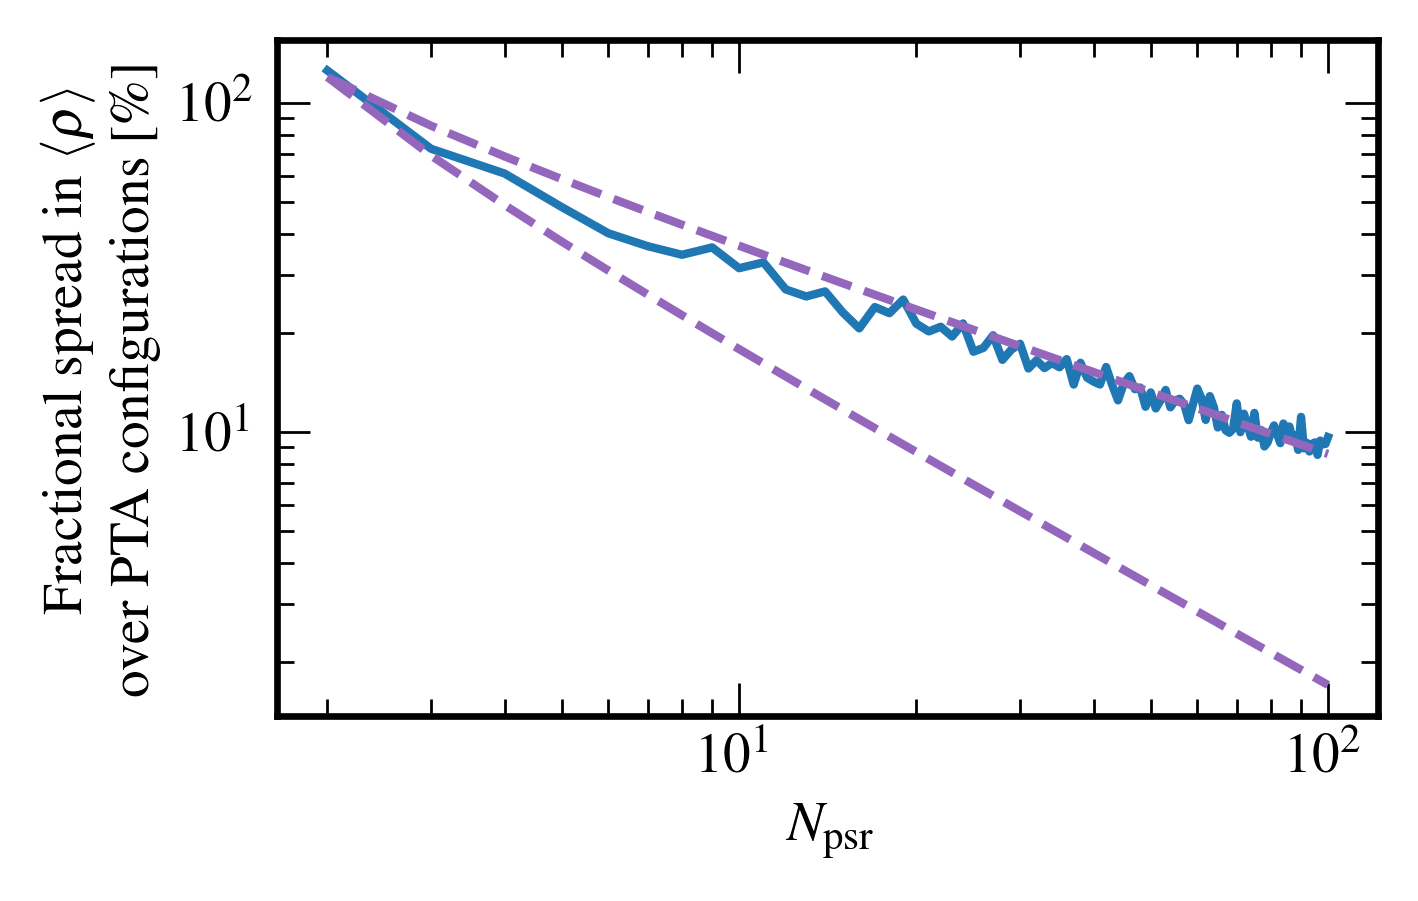

In [386]:
npairs = np.arange(2,101) * (np.arange(2,101)-1.) / 2.
plt.plot(np.arange(2,101), np.array(rho_fracspread_point)*100, color='C0')
#plt.plot(np.arange(2,101), 100 * np.exp(z(np.log(np.arange(2,101)))), color='C1', linestyle='dashed')
#plt.plot(np.arange(2,101), 100 * np.exp(-np.log(np.arange(2,101)) + 0.75), color='C2', linestyle='dashed')
#plt.plot(np.arange(2,101), 100 * 2./np.arange(2,101), color='C3', linestyle='dashed')
plt.plot(np.arange(2,101), 100 * 1.2/np.sqrt(npairs), color='C4', linestyle='dashed')
plt.plot(np.arange(2,101), 100 * 1.2/npairs**(0.31), color='C4', linestyle='dashed')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('$N_\mathrm{psr}$')
plt.ylabel(r'Fractional spread in $\langle\rho\rangle$ \\ over PTA configurations [$\%$]')

plt.minorticks_on()
plt.tick_params(which='both',direction='in',tick2On=True)
#plt.legend(loc='upper right',ncol=2,frameon=False)     

In [397]:
point_map = np.zeros(12288)
point_map[np.random.randint(0,len(hotspot))] = 12288.0

In [398]:
npsr = 500
theta = np.arccos(np.random.uniform(-1.,1.,size=npsr))
phi = np.random.uniform(0.,2.0*np.pi,size=npsr)

orf = orfFromMap_fast(np.column_stack([phi,theta]), point_map)
print (orf_overlap(orf,orf) / (npsr*(npsr-1.0)/2.))**0.5   

0.35889965891


## Realistic (bumpy) sky

In [358]:
realpop_map = np.load('./data/steve_realpop.npy')
realpop_map[realpop_map < 0.0] = 0.0

In [359]:
match_realpop = np.zeros((99,100))
for jj,npsr in enumerate(np.arange(2,101)):
    for ii in range(100):
        theta = np.arccos(np.random.uniform(-1.,1.,size=npsr))
        phi = np.random.uniform(0.,2.0*np.pi,size=npsr)

        orf = orfFromMap_fast(np.column_stack([phi,theta]), realpop_map)
        match_realpop[jj,ii] = orf_overlap(orf,orf) / (npsr*(npsr-1.0)/2.)
         
        if ii%100:
            clear_output()
            print '\r', npsr, ii
            sys.stdout.flush() 

100 99


In [365]:
np.save('orf_match_realpop_ptarandomize.npy',match_realpop)

In [360]:
match_realpop_spread = np.zeros((99,5))
for jj,npsr in enumerate(np.arange(2,101)):
    match_realpop_spread[jj,[0,4]] = np.array(confinterval(match_realpop[jj,:]**0.5, sigma=0.95, onesided=False))
    match_realpop_spread[jj,[1,3]] = np.array(confinterval(match_realpop[jj,:]**0.5, sigma=0.68, onesided=False))
    match_realpop_spread[jj,2] = np.mean(match_realpop[jj,:]**0.5)

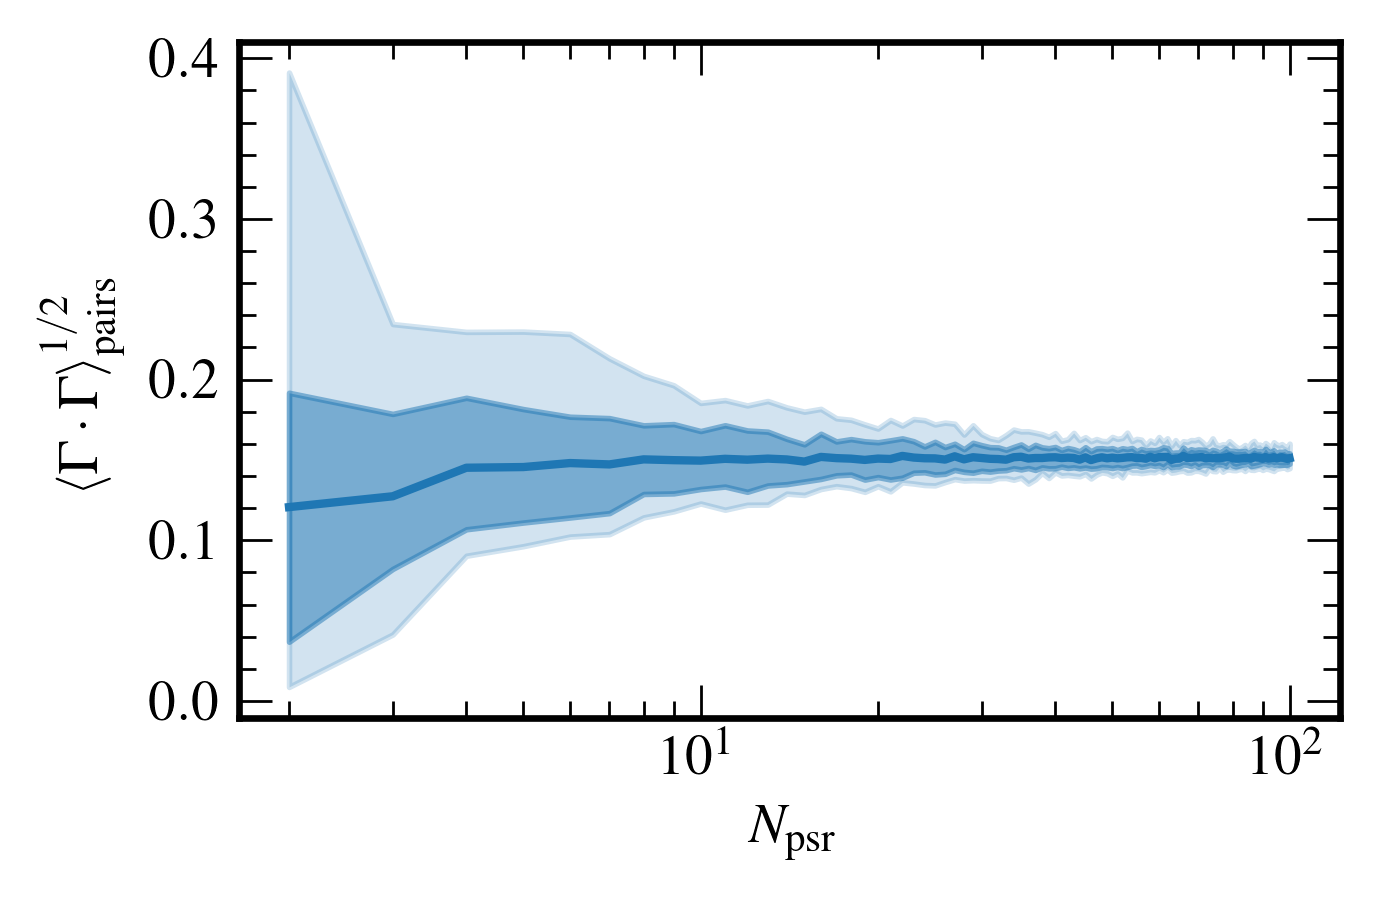

In [361]:
plt.fill_between(np.arange(2,101), match_realpop_spread[:,0], match_realpop_spread[:,4], color='C0', alpha=0.2)
plt.fill_between(np.arange(2,101), match_realpop_spread[:,1], match_realpop_spread[:,3], color='C0', alpha=0.5)

plt.plot(np.arange(2,101), match_realpop_spread[:,2], color='C0')

plt.xscale('log')

plt.xlabel('$N_\mathrm{psr}$')
plt.ylabel(r'$\langle \Gamma\cdot\Gamma \rangle_\mathrm{pairs}^{1/2}$')

plt.minorticks_on()
plt.tick_params(which='both',direction='in',tick2On=True)
#plt.legend(loc='upper right',ncol=2,frameon=False)     

In [362]:
rho_fracspread_realpop = []
for jj,npsr in enumerate(np.arange(2,101)):
    #rho_fracspread_point.append( np.diff(np.array(confinterval(match_realpop[jj,:]**0.5, sigma=0.68, onesided=False))) / 
    #                      np.mean(match_realpop[jj,:]**0.5) )
    rho_fracspread_realpop.append( np.std(match_realpop[jj,:]**0.5,ddof=1) / np.mean(match_realpop[jj,:]**0.5) )

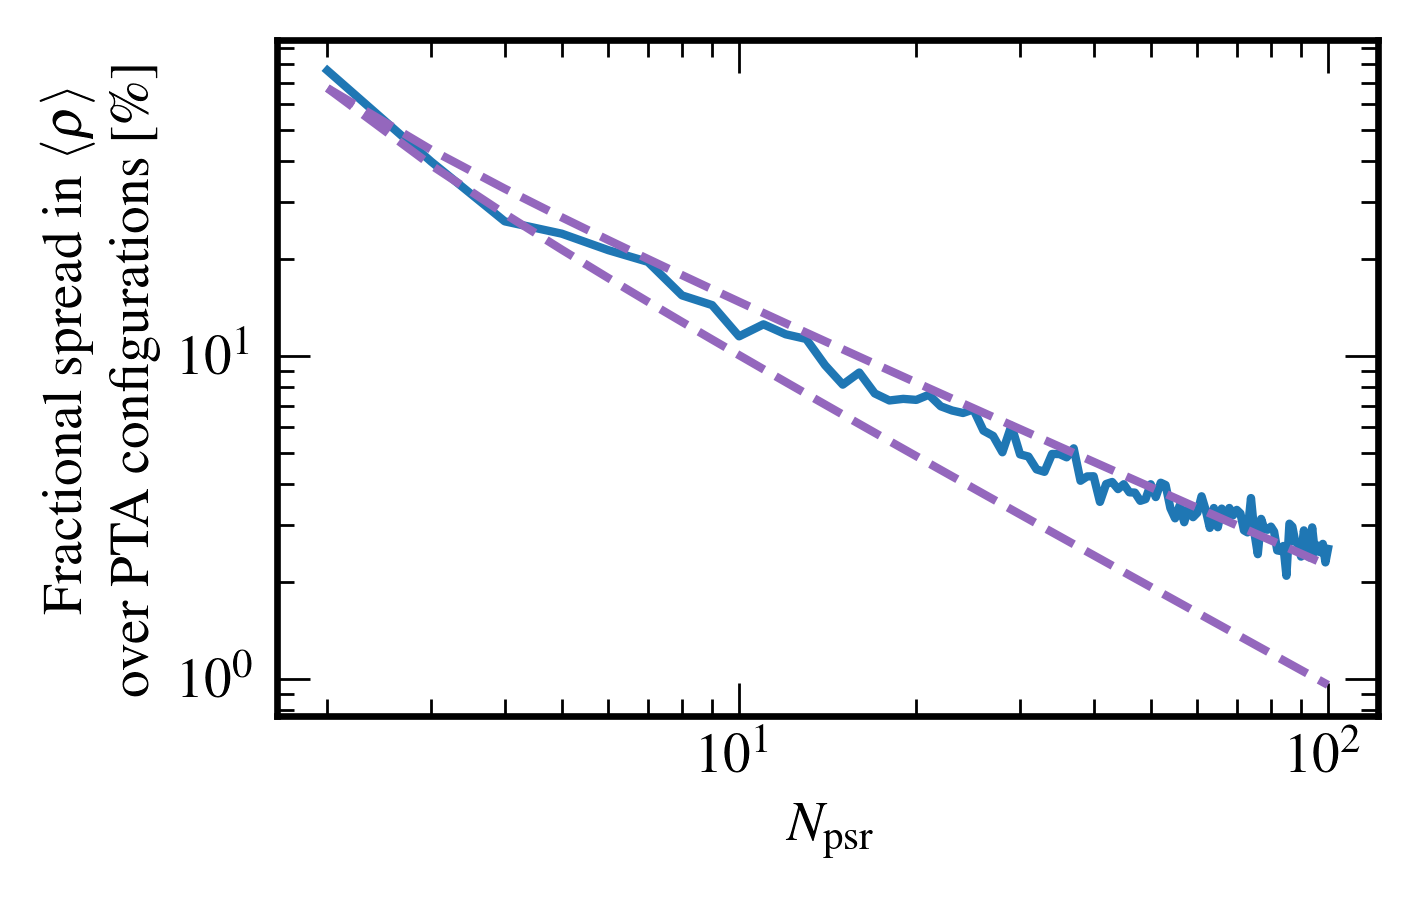

In [389]:
npairs = np.arange(2,101) * (np.arange(2,101)-1.) / 2.
plt.plot(np.arange(2,101), np.array(rho_fracspread_realpop)*100, color='C0')
#plt.plot(np.arange(2,101), 100 * np.exp(z(np.log(np.arange(2,101)))), color='C1', linestyle='dashed')
#plt.plot(np.arange(2,101), 100 * np.exp(-np.log(np.arange(2,101)) + 0.75), color='C2', linestyle='dashed')
#plt.plot(np.arange(2,101), 100 * 2./np.arange(2,101), color='C3', linestyle='dashed')
plt.plot(np.arange(2,101), 100 * 0.6738102648353916/np.sqrt(npairs), color='C4', linestyle='dashed')
plt.plot(np.arange(2,101), 100 * 0.6738102648353916/npairs**(0.4), color='C4', linestyle='dashed')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('$N_\mathrm{psr}$')
plt.ylabel(r'Fractional spread in $\langle\rho\rangle$ \\ over PTA configurations [$\%$]')

plt.minorticks_on()
plt.tick_params(which='both',direction='in',tick2On=True)
#plt.legend(loc='upper right',ncol=2,frameon=False)     